In [3]:
!git clone https://github.com/eimran/colab_test.git

Cloning into 'colab_test'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 43.17 KiB | 3.32 MiB/s, done.


In [5]:
!git status

SyntaxError: invalid syntax (ipython-input-3528599804.py, line 1)

In [ ]:
import torch
import torch .nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --------------------------
# 1. Generate Synthetic Data
# --------------------------

# Physics parameters
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

Define a small feed-forward neural network for h(t)

In [ ]:
# --------------------------------------------------------
# 2. Define a small feed-forward neural network for h(t)
# --------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

Helper for Automatic Differentiation

In [ ]:
# --------------------------------
# 3. Helper for Automatic Diff
# --------------------------------
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

Define the Loss Components (PINN)

In [ ]:
# ----------------------------------------
# 4. Define the Loss Components (PINN)
# ----------------------------------------

# We have:
#    (1) Data loss (fit noisy data)
#    (2) ODE loss: dh/dt = v0 - g * t
#    (3) Initial condition loss: h(0) = h0

def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)


Training Setup

In [ ]:
# ---------------------------------------
# 5. Training Setup
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 1.0
lambda_ode  = 1.0
lambda_ic   = 1.0

# For logging
num_epochs = 2000
print_every = 200

Training Loop

In [ ]:
# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/2000, Total Loss = 0.547967, Data Loss = 0.476178, ODE Loss = 0.034389, IC Loss = 0.037401
Epoch 400/2000, Total Loss = 0.531852, Data Loss = 0.478231, ODE Loss = 0.024723, IC Loss = 0.028898
Epoch 600/2000, Total Loss = 0.516125, Data Loss = 0.478232, ODE Loss = 0.020904, IC Loss = 0.016988
Epoch 800/2000, Total Loss = 0.511678, Data Loss = 0.476037, ODE Loss = 0.021543, IC Loss = 0.014098
Epoch 1000/2000, Total Loss = 0.508955, Data Loss = 0.473160, ODE Loss = 0.022258, IC Loss = 0.013536
Epoch 1200/2000, Total Loss = 0.506235, Data Loss = 0.470082, ODE Loss = 0.022992, IC Loss = 0.013162
Epoch 1400/2000, Total Loss = 0.503192, Data Loss = 0.466158, ODE Loss = 0.024184, IC Loss = 0.012851
Epoch 1600/2000, Total Loss = 0.500837, Data Loss = 0.462488, ODE Loss = 0.025675, IC Loss = 0.012674
Epoch 1800/2000, Total Loss = 0.499666, Data Loss = 0.460280, ODE Loss = 0.026755, IC Loss = 0.012630
Epoch 2000/2000, Total Loss = 0.498798, Data Loss = 0.459122, ODE Loss = 0.027055, IC 

Evaluate the Trained Model

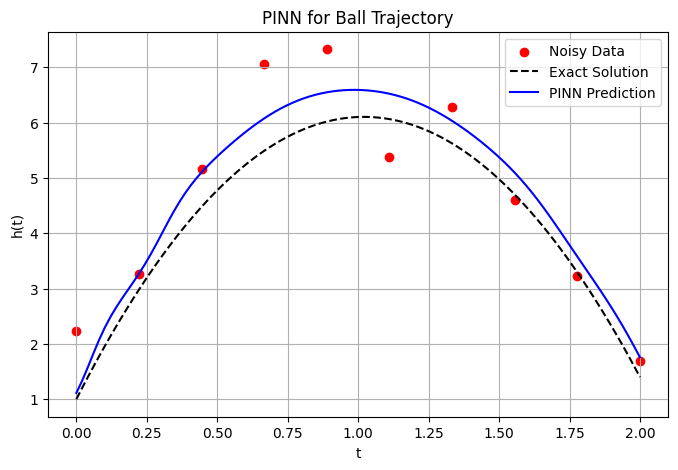

In [ ]:
# ---------------------------------------
# 7. Evaluate the Trained Model
# ---------------------------------------
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()